In [3]:
import ruamel.yaml as yaml
import os
import sys
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

NO_CONFIG_ERR_MSG = """No config file found. Root directory is determined by presence of "config.yaml" file."""

original_wd = os.getcwd()

# Number of times to move back in directory
num_retries = 10
for x in range(0, num_retries):
    # try to load config file
    try:
        with open("config.yaml", 'r') as stream:
            cfg = yaml.safe_load(stream)
    # If not found move back one directory level
    except FileNotFoundError:
        os.chdir('../')
        # If reached the max number of directory levels change to original wd and print error msg
        if x+1 == num_retries:
            os.chdir(original_wd)
            print(NO_CONFIG_ERR_MSG)

# Add directory to PATH
path = os.getcwd()

if path not in sys.path:
    sys.path.append(path)


## Load and Process Data

In [4]:
df = pd.read_csv('data/processed/modelling_data_dropped_null_wins.csv')

## Fit Model

In [5]:
df.head()

,Season_2014-15,Season_2015-16,Season_2016-17,Season_2017-18,Day_Of_WeekFri,Day_Of_WeekMon,Day_Of_WeekSat,Day_Of_WeekSun,Day_Of_WeekThu,Day_Of_WeekTue,...,player8_WINS,player8_RPM,player8_DRPM,player8_ORPM,player8_WINS_portion,player8_RPM_portion,Tot_WINS,Tot_RPM,Ticket_Value,TV_Rate
0,0,0,1,0,0,0,0,0,1,0,...,2.67,-0.60,-0.46,-0.14,0.000927,-0.000208,0.004895,-0.000510,0.671432,5.288334
1,0,0,1,0,0,0,0,0,1,0,...,0.05,-3.02,-0.06,-2.96,0.000016,-0.000968,0.006687,-0.008436,0.697920,5.698246
2,0,0,1,0,1,0,0,0,0,0,...,4.06,0.13,-1.23,1.36,0.001208,0.000039,0.005304,-0.000855,0.725555,4.477193
3,0,0,1,0,1,0,0,0,0,0,...,0.98,-0.26,0.13,-0.39,0.000204,-0.000054,0.006790,-0.011398,0.463623,3.068853
4,0,0,1,0,1,0,0,0,0,0,...,2.40,-0.68,-1.24,0.56,0.000833,-0.000236,0.006875,-0.001303,0.759319,4.683684


In [6]:
X = df.drop(columns=['Ticket_Value', 'TV_Rate'])
Y_Tickets = df['Ticket_Value']
Y_TV = df['TV_Rate']

In [8]:
best_params_tickets =  {'subsample': 0.8,
 'silent': 1,
 'seed': 42,
 'nthread': 4,
 'n_estimators': 500,
 'missing': -999,
 'min_child_weight': 11,
 'max_depth': 2,
 'learning_rate': 0.05,
 'colsample_bytree': 0.8}

best_params_TV = {'subsample': 0.5,
 'silent': 1,
 'seed': 42,
 'nthread': 4,
 'n_estimators': 5,
 'missing': -999,
 'min_child_weight': 11,
 'max_depth': 2,
 'learning_rate': 0.001,
 'colsample_bytree': 0.8}

In [45]:
import xgboost as xgb
gbr_tv = xgb.XGBRegressor()
gbr_tickets = xgb.XGBRegressor(**best_params_tickets)

In [46]:
from sklearn.model_selection import cross_val_score

In [47]:
%%time
scorers = ['neg_mean_squared_error', 'r2']
mse_tv = cross_val_score(gbr_tv, X, Y_TV, cv=5, scoring='neg_mean_squared_error')
mse_ticket = cross_val_score(gbr_tickets, X, Y_Tickets, cv=5, scoring='neg_mean_squared_error')

Wall time: 15.1 s


In [48]:
r2_tv = cross_val_score(gbr_tv, X, Y_TV, cv=10, scoring='explained_variance')
r2_ticket = cross_val_score(gbr_tickets, X, Y_Tickets, cv=10, scoring='explained_variance')

In [49]:
r2_tv = np.mean([x for x in r2_tv])
r2_ticket = np.mean([abs(x) for x in r2_ticket])

In [50]:
print(f'RMSE TV: {rmse_tv}')
print(f'RMSE Tickets: {rmse_tickets}')
print(f'R2 TV: {r2_tv}')
print(f'R2 Tickets: {r2_ticket}')      

RMSE TV: 5.490907774438297
RMSE Tickets: 0.25815280803812807
R2 TV: 0.7381597339208542
R2 Tickets: 0.3741427342046438


## Plot Partial Dependence

## Create PDP manually

Xaxis is val -- > 0 or 1
Y is output prediction

1) Make predictions with Avg Prediction (take mean columnwise)

2) Make Prediction when Superteam ==0, and when it ==1

3) Plot these two rows

In [8]:
avg_pred = pd.DataFrame(X.mean()).T
superteam_absent = avg_pred.assign(superteam_flg = 0)
superteam_present = avg_pred.assign(superteam_flg = 1)
pdp_predictions = pd.concat([superteam_absent, superteam_present])
pdp_predictions.index = ['Superteam_Absent', 'Superteam_Present']

In [9]:
pdp_predictions['TV_Rating_Predictions'] = gbr_tv.predict(pdp_predictions)
pdp_predictions['Ticket_Value_Predictions'] = gbr_tickets.predict(pdp_predictions.drop(columns='TV_Rating_Predictions'))

In [10]:
import altair as alt

In [11]:
pdp_predictions.head()

,Season_2014-15,Season_2015-16,Season_2016-17,Season_2017-18,Day_Of_WeekFri,Day_Of_WeekMon,Day_Of_WeekSat,Day_Of_WeekSun,Day_Of_WeekThu,Day_Of_WeekTue,...,player8_WINS,player8_RPM,player8_DRPM,player8_ORPM,player8_WINS_portion,player8_RPM_portion,Tot_WINS,Tot_RPM,TV_Rating_Predictions,Ticket_Value_Predictions
Superteam_Absent,0.0,0.0,0.497639,0.502361,0.183047,0.144421,0.15279,0.120386,0.088627,0.119742,...,1.83,-1.014193,0.073327,-1.08752,0.000462,-0.00027,0.005754,-0.002952,0.514071,0.404294
Superteam_Present,0.0,0.0,0.497639,0.502361,0.183047,0.144421,0.15279,0.120386,0.088627,0.119742,...,1.83,-1.014193,0.073327,-1.08752,0.000462,-0.00027,0.005754,-0.002952,0.533138,0.446597


In [29]:
pdp_predictions.diff()

,Season_2014-15,Season_2015-16,Season_2016-17,Season_2017-18,Day_Of_WeekFri,Day_Of_WeekMon,Day_Of_WeekSat,Day_Of_WeekSun,Day_Of_WeekThu,Day_Of_WeekTue,...,player8_WINS,player8_RPM,player8_DRPM,player8_ORPM,player8_WINS_portion,player8_RPM_portion,Tot_WINS,Tot_RPM,TV_Rating_Predictions,Ticket_Value_Predictions
Superteam_Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Superteam_Present,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019067,0.042303


In [22]:
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

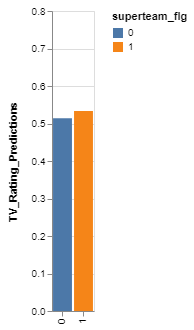

In [27]:
alt.Chart(pdp_predictions).mark_bar().encode(
    x=alt.X('superteam_flg:O', title=''),
    y=alt.Y('TV_Rating_Predictions:Q', scale=alt.Scale(domain=[0, .75])),
    color='superteam_flg:N'
)

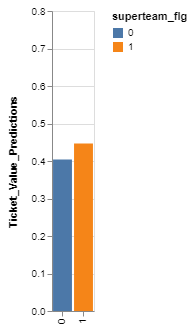

In [26]:
alt.Chart(pdp_predictions).mark_bar().encode(
    x=alt.X('superteam_flg:O', title=''),
    y=alt.Y('Ticket_Value_Predictions:Q', scale=alt.Scale(domain=[0, .75])),    
    color='superteam_flg:N'
)

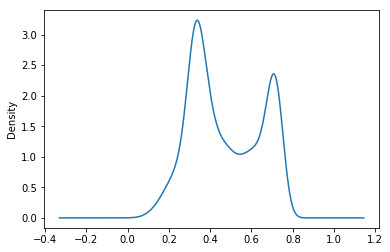

In [26]:
df['Ticket_Value'].plot(kind='kde')

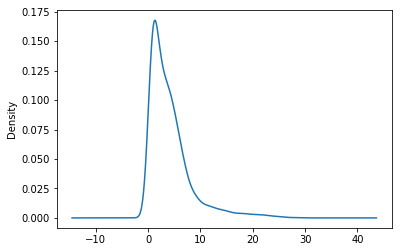

In [51]:
df['TV_Rate'].plot(kind='kde')

In [52]:

superteam_absent_2 = X.copy().assign(superteam_flg = 0).assign(superteam_status='absent')
superteam_present_2 = X.copy().assign(superteam_flg = 1).assign(superteam_status='present')
superteam_preds = pd.concat([superteam_absent_2, superteam_present_2])


In [55]:
gbr_tv = xgb.XGBRegressor()
gbr_tickets = xgb.XGBRegressor(**best_params_tickets)
gbr_tv.fit(X, Y_TV)
gbr_tickets.fit(X, Y_Tickets)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=11, missing=-999, n_estimators=500,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=1,
       subsample=0.8)

In [56]:
superteam_preds['TV_Rating_Predictions'] = gbr_tv.predict(superteam_preds.drop(columns=['superteam_status']))
superteam_preds['Ticket_Value_Predictions'] = gbr_tickets.predict(superteam_preds.drop(columns=['superteam_status', 'TV_Rating_Predictions']))

In [61]:
pd.concat([superteam_preds.groupby(by='superteam_flg').mean()['TV_Rating_Predictions'].to_frame('Avg_Output'),
          superteam_preds.groupby(by='superteam_flg').mean()['Ticket_Value_Predictions'].to_frame('Avg_Output'),
          ],
         )

,Avg_Output
superteam_flg,
0,3.380692
1,7.173040
0,0.464892
1,0.505969


In [58]:
superteam_preds.groupby(by='superteam_flg').mean()['Ticket_Value_Predictions']

superteam_flg
0    0.464892
1    0.505969
Name: Ticket_Value_Predictions, dtype: float32